# Chapter 4
## Numerical Solution of the Hodgkin-Huxley ODEs

In [2]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from input_factory import get_step_current

In [10]:
def plot_data(state_monitor, title=None):
    """Plots the state_monitor variables ["vm", "I_e", "m", "n", "h"] vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """

    plt.subplot(211)
    plt.plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2)

    plt.xlabel("t [ms]")
    plt.ylabel("v [mV]")
    plt.xlim(0, np.max(state_monitor.t / b2.ms))

    plt.subplot(212)

    plt.plot(state_monitor.t / b2.ms, state_monitor.m[0] / b2.volt, "black", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.n[0] / b2.volt, "blue", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.h[0] / b2.volt, "red", lw=2)
    plt.xlabel("t (ms)")
    plt.ylabel("act./inact.")
    plt.legend(("m", "n", "h"))
    plt.ylim((0, 1))

    plt.axis((
        0,
        np.max(state_monitor.t / b2.ms),
        0, 1
    ))
    if title is not None:
        plt.suptitle(title)

    plt.show();

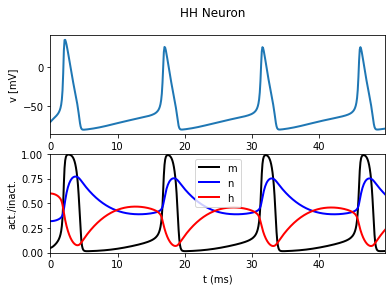

In [21]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import neurodynex3.tools.input_factory as input_factory



def simulate_HH_neuron(input_current, simulation_time):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = -59 * b2.mV
    EK = -82 * b2.mV
    ENa = 45 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = 120 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    
    alphan = 0.01/mV * (-60.0*mV - vm) / (exp((-60.0*mV - vm) / (10.0*mV)) - 1.0)/ms: Hz
    alpham = (vm + 45.0*mV) / (10.0*mV) / (1.0 - exp(-(vm + 45.0*mV) / (10.0*mV)))/ms : Hz
    alphah = 0.07*exp(-(vm + 70*mV)/(20*mV))/ms : Hz
    
    betan = 0.125 * exp(-(vm + 70.0*mV) / (80.0*mV))/ms: Hz
    betam = 4.0 * exp(-(vm + 70.0*mV) / (18.0*mV))/ms: Hz
    betah = 1. / (exp(-(vm + 40.0*mV) / (10.0*mV)) + 1.0)/ms : Hz
    
    dn/dt = alphan*(1-n)-betan*n : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dh/dt = alphah*(1-h)-betah*h : 1
    
    dvm/dt = membrane_Im/C : volt
    """
    
    neuron = b2.NeuronGroup(1, eqs, method="gsl")

    # parameter initialization [come from x_inf(v) {x:m,n,h}]
    neuron.vm = -70*b2.mV
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

current = input_factory.get_step_current(0, 50, b2.ms, 10.0 * b2.uA)
state_monitor = simulate_HH_neuron(current, 50 * b2.ms)
plot_data(state_monitor, title="HH Neuron")

In [47]:
def make_pulse(t_start, t_end, unit_time, amplitude, t_pulse, amp_pulse, pulse_time=1):
    """
    t_start and t_end are integers
    """
    tmp_size = 1 + t_end  # +1 for t=0
    tmp_size += 1
    tmp = np.zeros((tmp_size, 1)) * b2.amp
    tmp[t_start: t_end + 1 , 0] = amplitude
    tmp[t_pulse: t_pulse+pulse_time, 0] = amp_pulse
    curr = b2.TimedArray(tmp, dt=1. * unit_time)
    
    return curr

In [50]:
def plot_voltage(state_monitor, ax):
    ax.plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2, c='k')

    ax.set_xlabel("t [ms]")
    ax.set_ylabel("v [mV]")
    ax.set_ylim(-100, 50)
    ax.set_xlim(0, np.max(state_monitor.t / b2.ms))

def plot_current(state_monitor, ax, c="k"):
    ax.plot(state_monitor.t / b2.ms, state_monitor.I_e[0] / b2.uamp, lw=2, c=c)
    ax.set_xlim(0, np.max(state_monitor.t / b2.ms))
    ax.set_xlabel("t [ms]")
    ax.set_ylabel("I [micro A]")
    

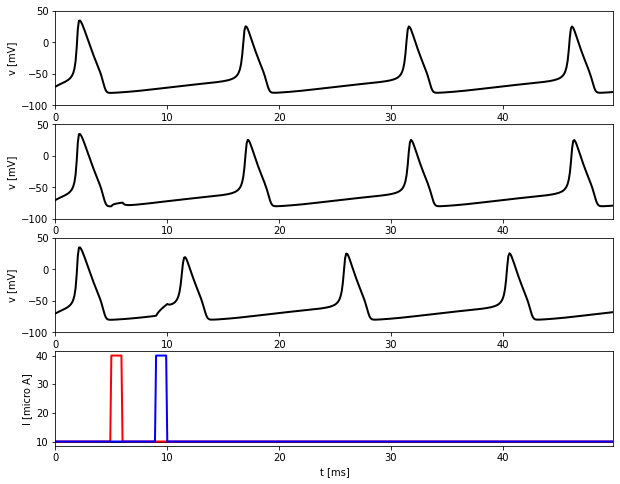

In [52]:
fig, ax = plt.subplots(4, figsize=(10, 8))

curr0 = get_step_current(0, 50, b2.ms, 10.0 * b2.uA)
curr1 = make_pulse(0, 50, b2.ms, 10*b2.uA, 5, 40*b2.uA )
curr2 = make_pulse(0, 50, b2.ms, 10*b2.uA, 9, 40*b2.uA )

stm0 = simulate_HH_neuron(curr0, 50 * b2.ms)
plot_voltage(stm0, ax[0])

stm1 = simulate_HH_neuron(curr1, 50 * b2.ms)
plot_voltage(stm1, ax[1])

stm2 = simulate_HH_neuron(curr2, 50 * b2.ms)
plot_voltage(stm2, ax[2])

plot_current(stm0, ax[3], c="k")
plot_current(stm1, ax[3], c="r")
plot_current(stm2, ax[3], c="b")

plt.show();

### Figure 4.3
An illustration of the refractoriness of the Hodgkin-Huxley
neuron following an action potential. Top panel: Solution already shown in Fig. 4.1. Middle panel: Solution obtained when a brief strong pulse of input is added, raising I from $10$ to $40 \mu A/cm^2$ for t between $5$ and $6$ ms. Bottom panel: Same, with additional input pulse arriving later, between $9$ and $10$ ms. 